In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [3]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [4]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [226]:
alpha = 0.1
beta = .5

dummy_optimizer = Optimizer()
def gradient_function(actor, critic):
    params = actor.trainable_weights
    # placeholder
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    values_input = tf.placeholder(tf.float32, shape=(None, 1))
    
    # q_func gradient tensor
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss1 = -K.sum(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss1, params)
    
    # discount factor gradient tensor
    discount = tf.expand_dims(- tf.exp(- alpha * actor_output[:,1]), 1)
    obj2 = tf.multiply(values_input, discount)
    loss2 = K.sum(obj2)
    gradient_for_d = dummy_optimizer.get_gradients(loss2, params)
    
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    func = K.function([state_input, values_input], gradient_tensor)
    
    return func

def gradient(states, values, gradient_func):
    gradient = gradient_func([states, values])
    return gradient


# Adam クラス
def learning_rate_arr(actor, size=674, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(674,) # 前回の勾配
        self.v = np.zeros(674,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [220]:
# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor, noise=False):
    memory = []
    S1 = np.linspace(-7, 7, 20)
    S2 = np.linspace(-7, 7, 20)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()
    
    ln = 1 if noise else 0
    n = 5 if noise else 1
    
    for _ in range(n):
        for i, x in enumerate(zip(S1, S2)):
            state0 = np.array(x)
            noise = np.array([np.random.randn() / 10., np.random.randn() / 100.])
            a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + ln*noise
            reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
            memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic, target_actor, target_critic, batch_size=32, epoch=5000):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = target_actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = target_critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# ターゲットネットワーク
def update_target_model(model, target_model, l=0.01):
    p = l * get_nn_params(model) + (1 - l) * get_nn_params(target_model)
    target_model = set_nn_params(target_model, p)
    return target_model

def clone_model(model, target_model):
    params = get_nn_params(model)
    target_model = set_nn_params(target_model, params)
    return target_model

# 評価
def evaluation(actor, init_state = np.array([1,2])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 30.:
            log.append([x, episode_time])
            break
    return episode_reward


In [227]:
# replay buffer の実装
class replay_buffer():
    def __init__(self, n_limits=30000):
        self.n_limits = n_limits
        self.memory = []
        
    def store(self, experience):
        # (s, a, r, s', e^-at)
        assert len(experience) == 5, 'shape error'
        self.memory.append(experience)
        if len(self.memory) >= self.n_limits:
            del self.memory[0]
        
    def sample(self, batch_size):
        batch = []
        idx_log = []
        while len(batch) < batch_size:
            idx = np.random.choice(range(len(self.memory)))
            candidate = self.memory[idx]
            if idx in idx_log:
                continue
            if np.random.rand() < candidate[-1]:
                idx_log.append(idx)
                batch.append(candidate)
        assert len(batch) == batch_size, ''
        return np.array(batch)
        
def reshape_data(data, mode=0):
    tmp = []
    for d in data:
        tmp.append(d)
    if mode==0:
        return np.array(tmp).reshape(len(data), 1, d.shape[0])
    else:
        return np.array(tmp).reshape(len(data), d.shape[0])

In [228]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
target_actor = branch_actor((2,),(2,))
target_critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
target_critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')

In [235]:
actor.load_weights('../saved_agent/mb_self_extend_noisy_actor.h5')
critic.load_weights('../saved_agent/mb_self_extend_noisy_critic.h5')
#actor.load_weights('../saved_agent/linear_init_extend_actor.h5')
#critic.load_weights('../saved_agent/linear_init_extend_critic.h5')
target_actor = clone_model(actor, target_actor)
target_critic = clone_model(critic, target_critic)
lrs = learning_rate_arr(actor, size=674, u_lr=.000001, tau_lr=.00001)
opt = Adam_original(lrs)
ev = evaluation(actor)
func = gradient_function(actor, critic)

In [236]:
print(f'value_function for initial policy = {ev}')

s = np.random.uniform(-7,7,2)
episode_time = 0
time_limit = 20.
batch_size = 32
buffer = replay_buffer(n_limits=30000)
n_warm_up = 10000
ev_log = [ev]

for i in range(1,n_warm_up+1000):
    u, tau = actor.predict_on_batch(s.reshape(1,1,2))[0]
    r, s_prime = interaction(s, u, tau, env, ln=0.1)
    buffer.store([s, np.array([u, tau]), r, s_prime, np.exp(- alpha * episode_time)])
    episode_time += tau
    s = s_prime
    if episode_time >= time_limit:
        s = np.random.uniform(-7,7,2)
        episode_time = 0
    if i < n_warm_up:
        continue
    #print(f'{i-n_warm_up}-step')
    batch = buffer.sample(batch_size)
    critic, losses = td_learning(batch[:,:4], actor, critic, target_actor, target_critic, batch_size=batch_size, epoch=1)
    critic_input = [actor.predict_on_batch(reshape_data(batch[:,3])), reshape_data(batch[:,3])]
    values = critic.predict_on_batch(critic_input)
    pg = flatten_gradient(gradient(reshape_data(batch[:,0],1), values, func))
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    ev = evaluation(actor)
    ev_log.append(ev)
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    print(f'{i}:step, ev = {ev}\r',end='')
    #print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    #print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -19.790268460592287


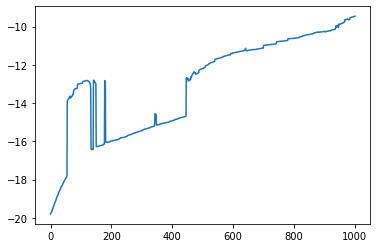

In [237]:
plt.plot(ev_log)

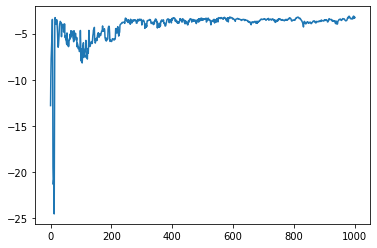

In [138]:
plt.plot(ev_log)

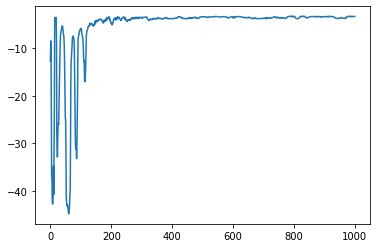

In [107]:
plt.plot(ev_log)

In [240]:
env.reset()
# actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
# actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
initial_state = np.array([-1., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

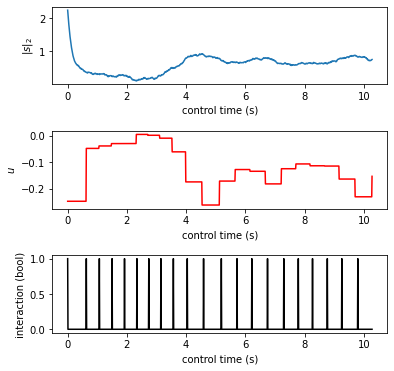

In [241]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [234]:
actor.save_weights('../saved_agent/learned_self_linear_proposed2_actor.h5')
critic.save_weights('../saved_agent/learned_self_linear_proposed2_critic.h5')

In [188]:
sr = '''
value_function for initial policy = -19.790268460592287
1-step
loss of critic is 0.023121803998947144, value_fuction V(s) = -19.55308732151059
|g| = 16643.073177875543
2-step
loss of critic is 0.0208317581564188, value_fuction V(s) = -19.25167115640579
|g| = 5979.887947328352
3-step
loss of critic is 0.03725593909621239, value_fuction V(s) = -18.924642705106677
|g| = 12531.023459532773
4-step
loss of critic is 0.02475639060139656, value_fuction V(s) = -18.53073920107265
|g| = 17882.869913455295
5-step
loss of critic is 0.039436887949705124, value_fuction V(s) = -18.14848279469456
|g| = 10875.517532714002
6-step
loss of critic is 0.03984421119093895, value_fuction V(s) = -17.757225868019948
|g| = 7047.804481185579
7-step
loss of critic is 0.028146015480160713, value_fuction V(s) = -17.37763021878224
|g| = 9630.984925595672
8-step
loss of critic is 0.03756727650761604, value_fuction V(s) = -13.241374211768445
|g| = 6406.487272346342
9-step
loss of critic is 0.03536154702305794, value_fuction V(s) = -12.898584682541076
|g| = 4617.823008123921
10-step
loss of critic is 0.04224872216582298, value_fuction V(s) = -12.592020121996782
|g| = 8011.610707696658
11-step
loss of critic is 0.039233509451150894, value_fuction V(s) = -12.27569745353927
|g| = 6315.896906607074
12-step
loss of critic is 0.053879451006650925, value_fuction V(s) = -11.772376556895106
|g| = 5601.268922555551
13-step
loss of critic is 0.05825607478618622, value_fuction V(s) = -11.353472231386663
|g| = 6243.170534559078
14-step
loss of critic is 0.07237794995307922, value_fuction V(s) = -11.043308807177791
|g| = 3669.7260382320246
15-step
loss of critic is 0.06406601518392563, value_fuction V(s) = -10.751289995632726
|g| = 4343.76920572198
16-step
loss of critic is 0.04957537725567818, value_fuction V(s) = -10.465973920213548
|g| = 4344.6754822404755
17-step
loss of critic is 0.06941671669483185, value_fuction V(s) = -10.236510843612969
|g| = 6907.8864410828455
18-step
loss of critic is 0.06542089581489563, value_fuction V(s) = -9.951824637608567
|g| = 4779.862765630935
19-step
loss of critic is 0.04379097372293472, value_fuction V(s) = -9.736930059633616
|g| = 5195.641982566649
20-step
loss of critic is 0.057551827281713486, value_fuction V(s) = -9.536599468662025
|g| = 6569.338576606895
21-step
loss of critic is 0.07236030697822571, value_fuction V(s) = -9.475696323845343
|g| = 6574.4203177620375
22-step
loss of critic is 0.07667481154203415, value_fuction V(s) = -9.389416018565305
|g| = 6113.322518530459
23-step
loss of critic is 0.0790068730711937, value_fuction V(s) = -9.11183336619899
|g| = 5807.341191833905
24-step
loss of critic is 0.0658675879240036, value_fuction V(s) = -11.778446406812966
|g| = 3959.375152788474
25-step
loss of critic is 0.08111182600259781, value_fuction V(s) = -8.967245456858171
|g| = 3083.061232502283
26-step
loss of critic is 0.09653119742870331, value_fuction V(s) = -11.321331838188286
|g| = 5633.1001203488795
27-step
loss of critic is 0.08830844610929489, value_fuction V(s) = -8.760726288236684
|g| = 6249.531742561965
28-step
loss of critic is 0.12120741605758667, value_fuction V(s) = -8.749712957854898
|g| = 4073.4195866395667
29-step
loss of critic is 0.1369268298149109, value_fuction V(s) = -10.657491524323197
|g| = 5922.536642765194
30-step
loss of critic is 0.10857155174016953, value_fuction V(s) = -10.433836311352046
|g| = 5925.146478198241
31-step
loss of critic is 0.12032770365476608, value_fuction V(s) = -10.308426135470844
|g| = 6176.702927963024
32-step
loss of critic is 0.11714506149291992, value_fuction V(s) = -10.20312764063229
|g| = 9623.346093933953
33-step
loss of critic is 0.1218341514468193, value_fuction V(s) = -10.069115780969607
|g| = 9542.817873501877
34-step
loss of critic is 0.1409940868616104, value_fuction V(s) = -9.765082403603119
|g| = 10764.498838344716
35-step
loss of critic is 0.15490353107452393, value_fuction V(s) = -8.570577175530266
|g| = 9020.040110616808
36-step
loss of critic is 0.12406569719314575, value_fuction V(s) = -8.526816334682417
|g| = 11771.415123544692
37-step
loss of critic is 0.14931508898735046, value_fuction V(s) = -8.527406014784354
|g| = 10153.898937609922
38-step
loss of critic is 0.13802984356880188, value_fuction V(s) = -8.355563433225907
|g| = 9514.318249405589
39-step
loss of critic is 0.143002450466156, value_fuction V(s) = -8.240935043487859
|g| = 7577.186385864883
40-step
loss of critic is 0.18729902803897858, value_fuction V(s) = -8.090895087188917
|g| = 6533.238535346305
41-step
loss of critic is 0.18165770173072815, value_fuction V(s) = -7.945683973417282
|g| = 4881.947209939254
42-step
loss of critic is 0.14743568003177643, value_fuction V(s) = -7.804655691526367
|g| = 4849.934947776549
43-step
loss of critic is 0.20272193849086761, value_fuction V(s) = -7.666821547670399
|g| = 7144.121424386905
44-step
loss of critic is 0.2555265724658966, value_fuction V(s) = -7.534014538416162
|g| = 6042.059047351611
45-step
loss of critic is 0.19888333976268768, value_fuction V(s) = -7.371705288236821
|g| = 3570.241571163717
46-step
loss of critic is 0.2558951675891876, value_fuction V(s) = -7.237676519030983
|g| = 6292.148623166309
47-step
loss of critic is 0.30614957213401794, value_fuction V(s) = -7.02529854719764
|g| = 4510.961622038501
48-step
loss of critic is 0.356555312871933, value_fuction V(s) = -6.860066485668009
|g| = 2986.38813623383
49-step
loss of critic is 0.6435253024101257, value_fuction V(s) = -6.734242334497093
|g| = 3776.30542335412
50-step
loss of critic is 0.708459198474884, value_fuction V(s) = -6.681333562942978
|g| = 3923.593919313346
51-step
loss of critic is 0.5190606713294983, value_fuction V(s) = -6.5304328869687005
|g| = 3638.680897725543
52-step
loss of critic is 0.4783051311969757, value_fuction V(s) = -6.467625881864901
|g| = 4184.883291050708
53-step
loss of critic is 0.6406337022781372, value_fuction V(s) = -6.438538511416325
|g| = 3613.533010852106
54-step
loss of critic is 0.7108331322669983, value_fuction V(s) = -6.3860088036374485
|g| = 4212.429169320046
55-step
loss of critic is 0.8893885016441345, value_fuction V(s) = -6.21215114314842
|g| = 6794.283976012891
56-step
loss of critic is 0.9159796237945557, value_fuction V(s) = -6.009567460288168
|g| = 5334.902109772176
57-step
loss of critic is 0.8199454545974731, value_fuction V(s) = -6.1367154998064635
|g| = 3373.74901654913
58-step
loss of critic is 1.0691827535629272, value_fuction V(s) = -6.127663065092491
|g| = 3115.0478272224727
59-step
loss of critic is 1.2626550197601318, value_fuction V(s) = -6.027659446291228
|g| = 5129.218183896601
60-step
loss of critic is 1.197506308555603, value_fuction V(s) = -5.9341389401119695
|g| = 2632.8761611859645
61-step
loss of critic is 0.9151600003242493, value_fuction V(s) = -5.832853710999658
|g| = 7834.6242733736135
62-step
loss of critic is 0.8397366404533386, value_fuction V(s) = -5.368217275334113
|g| = 5333.394883064633
63-step
loss of critic is 1.2286015748977661, value_fuction V(s) = -6.0381193097333465
|g| = 2663.972071643032
64-step
loss of critic is 0.9633839726448059, value_fuction V(s) = -5.015023009677241
|g| = 2277.0071240577954
65-step
loss of critic is 1.174142599105835, value_fuction V(s) = -4.906908580369574
|g| = 2077.066934650117
66-step
loss of critic is 8.253662109375, value_fuction V(s) = -5.556018232931089
|g| = 5339.725604602239
67-step
loss of critic is 5.573827266693115, value_fuction V(s) = -5.610260888466169
|g| = 25902.450377263307
68-step
loss of critic is 9.422638893127441, value_fuction V(s) = -5.5311034143135
|g| = 9159.609095256415
69-step
loss of critic is 5.91696834564209, value_fuction V(s) = -5.63387082859281
|g| = 5662.561361594012
'''

In [189]:
l = []
rs = []
for s in sr:
    if s != '\n':
        l.append(s)
    else:
        if len(l) > 30:
            #print(''.join([k for k in l[-19:] if k != '=']), len(l))
            rs.append(float(''.join([k for k in l[-19:] if k != '='])))
        l = []

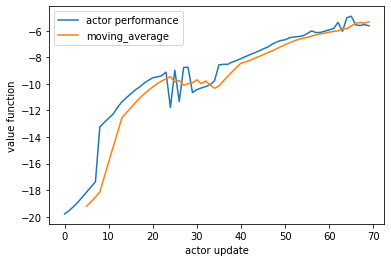

In [190]:
#rs = rs[15:]
m = 5
plt.plot(rs, label='actor performance')
plt.plot(range(m, len(rs)), moving_average(rs,m), label='moving_average')
plt.xlabel('actor update')
plt.ylabel('value function')
plt.legend()

In [191]:
with open('../csv/improvement.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(l)